# Interview challenge - Junior Data Scientist
This programming exercise is developed by Nicolás Pérez de Olaguer on Friday & Saturday 04-05.03.2021.

Importing required libraries, for installing, please run: `pip install -r requirements.txt` on the given file to make sure all dependencies are matched.

In [1]:
import os
import typing
import logging
import math
import csv

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report


Defining styling plots

In [2]:
# Set matplotlib style
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Set seaborn style
sns.set_theme(style="ticks", color_codes=True)

# Avoid Pandas false positive warning message when chained assignemnt.
pd.options.mode.chained_assignment = None 

## Load and familiarize with the dataset. Are there any issues, that could disturb further analyses?

Here, I use the created function to load the data as a Pandas DataFrame. To analyse the data, I will check the range of the data, the mean and standard deviation. Also, I will inspect into missing or repeated measures.

In [3]:
current_path = os.getcwd()

# Defining the filename
filename = 'challenge_juniorDS_feb2021.csv'

file_path = os.path.join(current_path, filename)

# Loading data from the given file
raw_data = pd.read_csv(file_path, sep=';', parse_dates=['date'])

In [4]:
# See the first ten rows of the data for familarizing
raw_data.head(n=10)

,nir_1366,nir_1378,nir_1390,nir_1402,nir_1414,nir_1426,nir_1438,nir_1450,nir_1462,nir_1474,...,nir_2518,nir_2530,device_id,label1,label2,field_id,position_id,spot_id,mID,date
0,0.363926,0.350865,0.330383,0.297856,0.274306,0.267428,0.263071,0.262623,0.260094,0.264123,...,0.151945,0.151691,6,good,issue_1,field_6,1,1,514234,2020-03-04
1,0.352420,0.341933,0.320079,0.289949,0.261719,0.256643,0.253282,0.252888,0.250116,0.255253,...,0.145378,0.145107,6,good,issue_1,field_6,1,1,514236,2020-03-04
2,0.352814,0.345784,0.322058,0.291212,0.264951,0.256647,0.254134,0.252345,0.252983,0.256853,...,0.144151,0.143970,6,good,issue_1,field_6,1,1,514238,2020-03-04
3,0.382781,0.371203,0.356452,0.330397,0.306710,0.308089,0.306187,0.305090,0.303479,0.308517,...,0.200565,0.200643,5,bad,issue_4,field_6,2,1,514248,2020-03-04
4,0.372411,0.366229,0.347437,0.322621,0.299037,0.298630,0.293724,0.296257,0.295536,0.297862,...,0.185979,0.186190,5,bad,issue_4,field_6,2,1,514251,2020-03-04
5,0.377337,0.371954,0.350394,0.325345,0.303041,0.300181,0.297893,0.298587,0.300049,0.300989,...,0.185943,0.185980,5,bad,issue_4,field_6,2,1,514253,2020-03-04
6,0.656370,0.651822,0.634788,0.611317,0.588405,0.585875,0.584247,0.590157,0.590410,0.593797,...,0.351301,0.349905,6,bad,issue_4,field_6,1,2,514275,2020-03-04
7,0.644057,0.637080,0.621609,0.597203,0.572212,0.572283,0.569114,0.575224,0.575041,0.581916,...,0.335294,0.333695,6,bad,issue_4,field_6,1,2,514278,2020-03-04
8,0.632936,0.630511,0.611989,0.587365,0.564702,0.561515,0.561180,0.566006,0.565514,0.572254,...,0.324276,0.322656,6,bad,issue_4,field_6,1,2,514281,2020-03-04
9,0.416926,0.410954,0.387006,0.347756,0.312454,0.310442,0.305471,0.306490,0.305229,0.311784,...,0.182683,0.183629,5,good,issue_1,field_6,2,2,514287,2020-03-04


In [5]:
# Divide the data frame in sensor data and descriptive data(device id, labels, etc.)

misc_cols = ['device_id','label1', 'label2', 'field_id', 'position_id', 'spot_id', 'mID', 'date']
misc_data = raw_data[misc_cols]

sensor_data = raw_data[raw_data.columns[:-8]]

# Use describe function on sensor data to see numerical insights.
sensor_data.describe()

,nir_1366,nir_1378,nir_1390,nir_1402,nir_1414,nir_1426,nir_1438,nir_1450,nir_1462,nir_1474,...,nir_2422,nir_2434,nir_2446,nir_2458,nir_2470,nir_2482,nir_2494,nir_2506,nir_2518,nir_2530
count,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,...,3255.000000,3245.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000
mean,0.461986,0.456047,0.436573,0.405898,0.379867,0.369946,0.363700,0.361569,0.362057,0.368423,...,0.304736,0.294088,0.283271,0.273448,0.264693,0.257002,0.250531,0.245930,0.243934,0.244693
std,0.123436,0.122259,0.120040,0.117140,0.114735,0.114571,0.114273,0.115337,0.115473,0.116695,...,0.110678,0.108497,0.106025,0.103926,0.102130,0.100471,0.098712,0.097063,0.096025,0.095889
min,0.158427,0.156436,0.150367,0.139220,0.132487,0.128851,0.129232,0.127951,0.127853,0.129593,...,0.117236,0.111219,0.105288,0.099801,0.094871,0.090822,0.087974,0.086153,0.085429,0.085229
25%,0.372021,0.366552,0.347579,0.318338,0.293605,0.283921,0.277840,0.274829,0.275479,0.281025,...,0.226552,0.218064,0.209222,0.201085,0.193896,0.187233,0.182171,0.178855,0.177905,0.179132
50%,0.439210,0.432522,0.409779,0.377227,0.349076,0.339321,0.333369,0.330014,0.330375,0.335919,...,0.272137,0.262160,0.252087,0.243310,0.235329,0.228084,0.222199,0.218154,0.216262,0.217378
75%,0.528149,0.523614,0.502759,0.471960,0.443830,0.434771,0.427982,0.426029,0.426977,0.433981,...,0.362674,0.350028,0.336672,0.324423,0.313814,0.304354,0.296260,0.291058,0.288911,0.289793
max,0.967581,0.953759,0.920279,0.882653,0.836247,0.821138,0.815676,0.815602,0.815586,0.825605,...,0.821080,0.809547,0.798205,0.788065,0.779368,0.771717,0.764063,0.757738,0.754751,0.755718


Also, an intuitive way to see how the data is distributed is too look at a colorscale plot. Since we have a lot of data, this will give coarse information such as: possible correlations and potential problems.

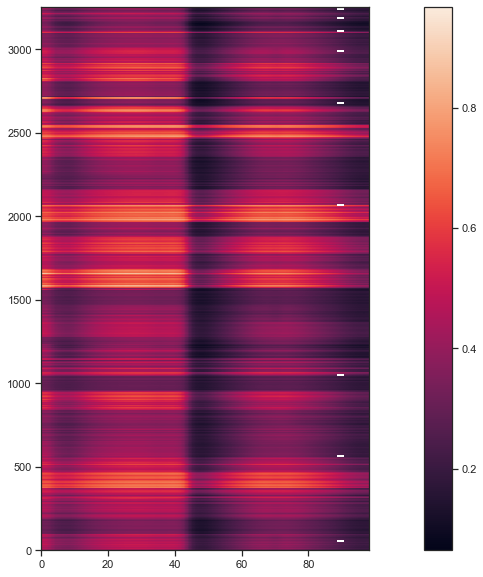

In [6]:
plt.imshow(sensor_data, origin='upper', extent = [0, 98, 0, 3255], aspect = 0.05)
plt.colorbar()

This plot already tell us that there might be correlation among rows (measurements) since we see horizontal color patterns. The visible vertical patterns also show correlation among wavelenght sensor data. Also, we see that there is missing data in one specific column. 

Moreover, the data is bounded to the [0,1] range, i.e., normalized. Depending on which model do we want to build later on, it would be useful to check standard deviation of all the measures and see if they are similar. 

Now we look int the other non-numerical data.

In [7]:
# Change devide_id, position_id, spot_id and m_id to categorical data
to_categorical = [ 'device_id', 'field_id', 'position_id', 'spot_id']

misc_data[to_categorical] = misc_data[to_categorical].astype('category')
raw_data[to_categorical] = raw_data[to_categorical].astype('category')

# data insights - dropping date since gives warning for describe function
misc_data.drop(['date','mID'], axis=1).describe()

,device_id,label1,label2,field_id,position_id,spot_id
count,3255,3233,3233,3255,3255,3255
unique,10,2,6,35,5,3
top,6,good,issue_1,field_14,1,1
freq,528,2911,2541,114,692,1150


Here we can already see the possible value representation of the non-numerical. We already see that the label fields have missing values. Let's investigate this... 

In [8]:
# Check for unique values
misc_data.apply(lambda col: col.nunique(), axis=0)

device_id        10
label1            2
label2            6
field_id         35
position_id       5
spot_id           3
mID            3255
date             30
dtype: int64

I also make sure that the data has no repeated values by checking its unique values. There are no repeated measurements since all the measurements IDs (mID) are unique and matching the number of data rows. 

In [9]:
# Look for missing values
counts = raw_data.isna().sum(axis=0)
counts[counts > 0]

nir_2434    10
label1      22
label2      22
dtype: int64

There is missing data in the sensor measurements as well as in the given labels. Specifically, there are a total of 10 missing nir_2434 sensor values and 22 missing label1 and label2. 

As imputation for the numerical data, I will replace the missing values with the mean over measurement, i.e., row. Before the data analysis, the row data seems to be correlated as it is dependent from the location and field. Thus, replacing by the mean of every measurment will have the least impact on the data.

In [10]:
# Imputating the missing values for row means
sensor_data = sensor_data.apply(lambda row: row.fillna(row.mean()), axis=1)
raw_data = pd.concat([sensor_data, misc_data], axis=1)

Let's now look into the distribution of the data with respect to the given labels. I will plot randomly slected sensor data across measurements to see the predictive power of the sensor data (columns). 

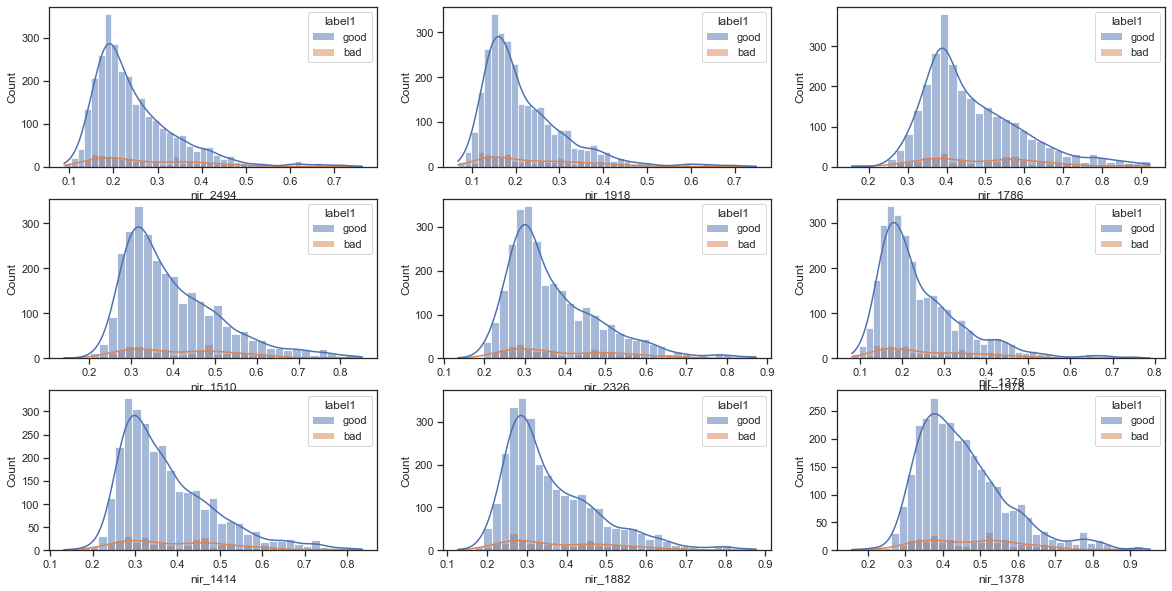

In [11]:
# For Label 1
f, axes = plt.subplots(3, 3)
random_columns = np.random.choice([c for c in sensor_data], size=9)

for col, ax in zip(random_columns, axes.flatten()):
    sns.histplot(raw_data, x=col, hue='label1', kde=True, ax=ax)
    plt.title(col)
plt.show()

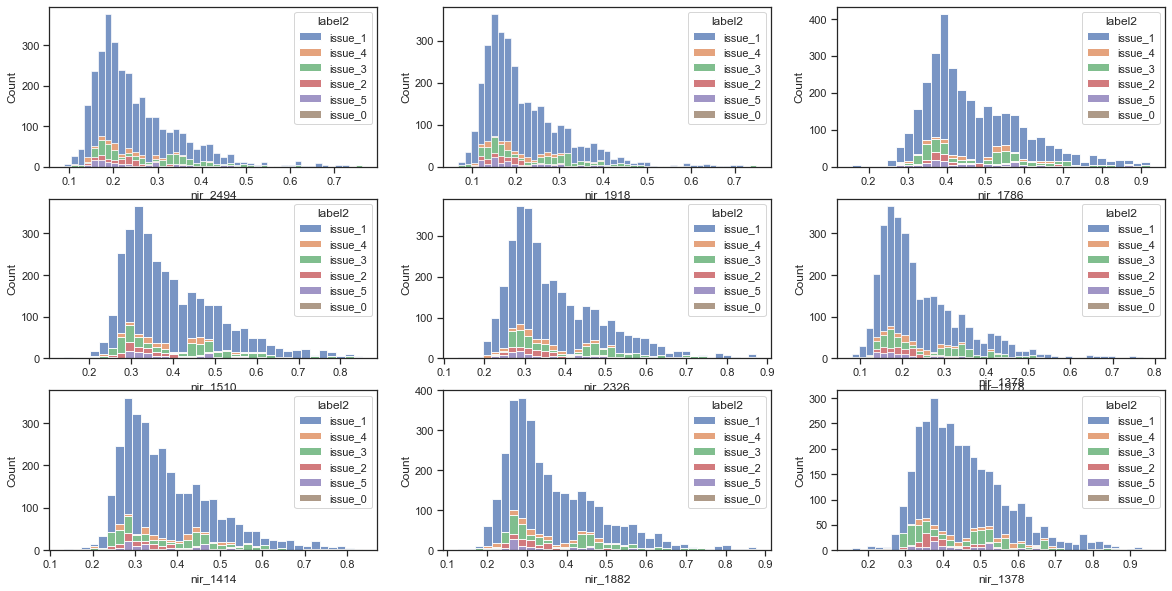

In [12]:
# For label 2
f1, axes = plt.subplots(3, 3)

for col, ax in zip(random_columns, axes.flatten()):
    sns.histplot(raw_data, x=col, hue='label2', multiple="stack", ax=ax)
    plt.title(col)
plt.show()

The distribution of the measurement data appears to be similar for different sensors. This might tell us that the sensor data itself does not have much predictive power for the labels. Therefore, we can do two things:
1. Reduce the dimensionality of the data per measurement across sensors, e.g. compute the mean across sensors per measurement.
2. Transofrm the data in a way that every single measurement has labels assigned to them. This will increase the number of rows of our data and we won't loose any information (compared to the mean).  

Finally, I will analyse the distribution of the actual near infrared (NIR) wavelenghts. This might be useful to get insights on the actual meaning of the data and if it has a uniform distribution. 

(0    1366
dtype: int64, 0    2530
dtype: int64)


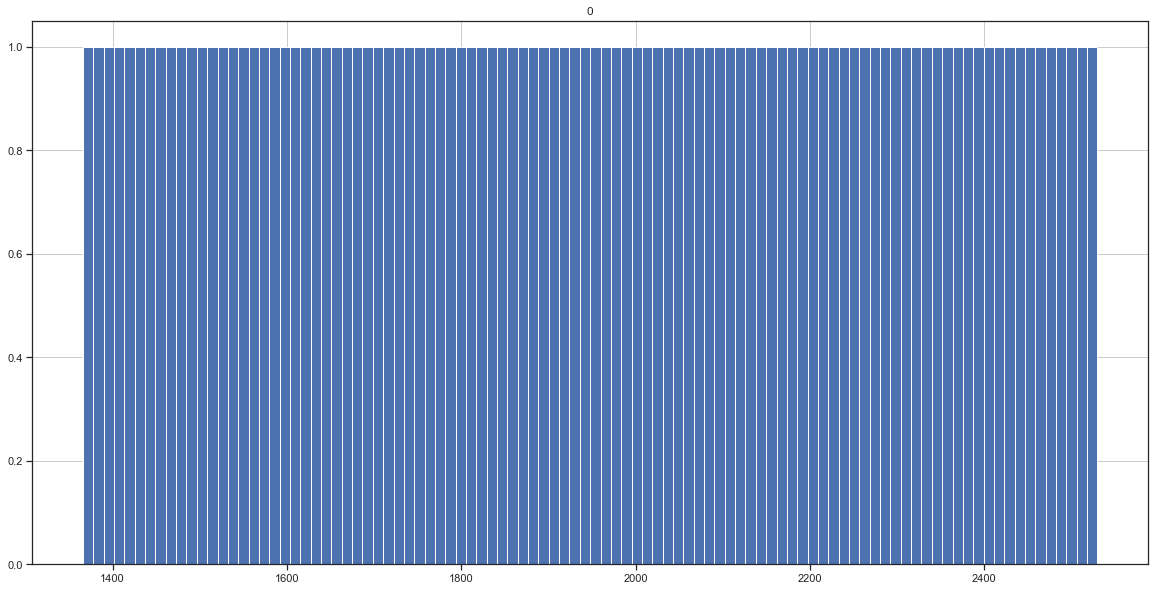

In [13]:
# Analyzing the distribution of the measured wavelenghts

# Get the column values and remove the nir string 
w_lenghts = list(sensor_data.columns.values)
w_lenghts = pd.DataFrame([int(wlen.replace('nir_','')) for wlen in w_lenghts])

# Plot histogram to see distribution 
w_lenghts.hist(bins=len(w_lenghts))
print((w_lenghts.min(), w_lenghts.max()))

We can see that there is a uniform distribution of the wavelenghts across the 1366 to 2530 nm. Therefore, there is no need to modify the data.

## Evaluation of the variation of spectral data per field.

First, let's analyze how many measurement per field we have. 

<AxesSubplot:>

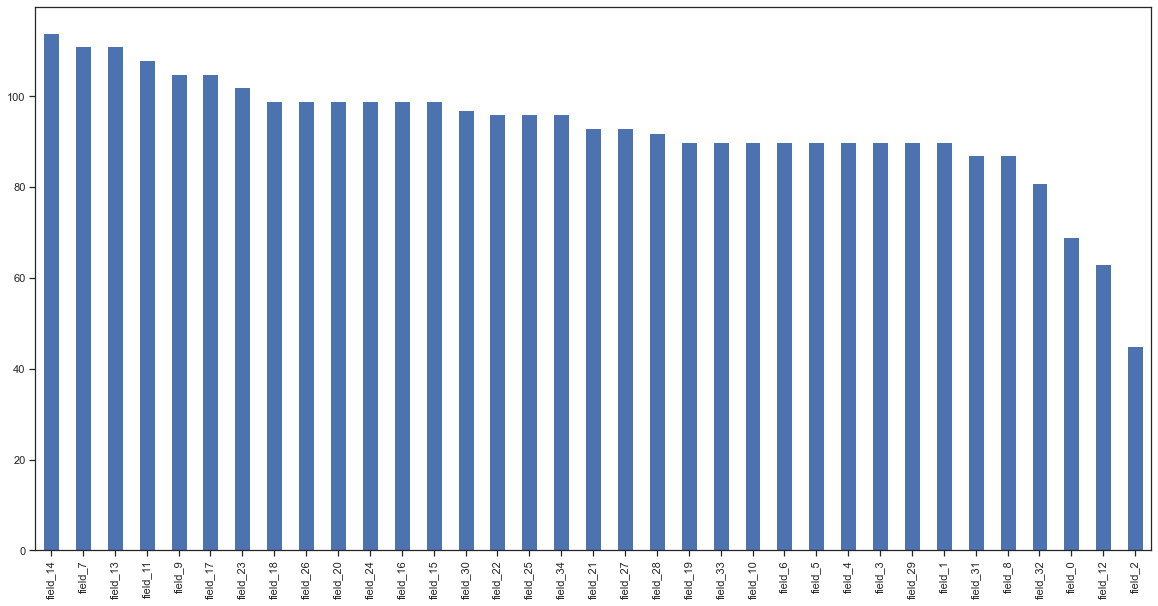

In [14]:
# How many measurements per field
raw_data['field_id'].value_counts().plot(kind='bar')

We see that there are uniformly distributed number of measurements per field at around 90 measurements. Also, we see that fields 0, 2 and 12 have significant less number of measurements. 

As previously explained, as preprocessing, I will generate two different data frames. One with the means of the sensor data and one with the wide-to-long transformation of the measurements. 

Also, since we are interested in the the spatial distribution, I will join the __field_id__,__position_id__ and __spot_id__ and add it as a new variable to the data as __location__. This variable will hopefully be useful for the model creation.

In [15]:
# Generate mean Data Frame and show distribution 
mean_df = pd.DataFrame({'measurement_mean': sensor_data.mean(axis=1), 
                        'measurement_std': sensor_data.std(axis=1)})
mean_df = pd.concat([mean_df, misc_data], axis=1)

# Add new location variable as a column
mean_df['location'] = mean_df.apply(lambda row: f'{row.field_id}, {row.position_id}, {row.spot_id}', axis=1)

mean_df

,measurement_mean,measurement_std,device_id,label1,label2,field_id,position_id,spot_id,mID,date,location
0,0.256919,0.061624,6,good,issue_1,field_6,1,1,514234,2020-03-04,"field_6, 1, 1"
1,0.249754,0.061775,6,good,issue_1,field_6,1,1,514236,2020-03-04,"field_6, 1, 1"
2,0.250700,0.063061,6,good,issue_1,field_6,1,1,514238,2020-03-04,"field_6, 1, 1"
3,0.295719,0.054857,5,bad,issue_4,field_6,2,1,514248,2020-03-04,"field_6, 2, 1"
4,0.285237,0.057200,5,bad,issue_4,field_6,2,1,514251,2020-03-04,"field_6, 2, 1"
...,...,...,...,...,...,...,...,...,...,...,...
3250,0.221683,0.055662,10,good,issue_1,field_30,4,3,666626,2021-01-14,"field_30, 4, 3"
3251,0.221925,0.056591,10,good,issue_1,field_30,4,3,666629,2021-01-14,"field_30, 4, 3"
3252,0.392435,0.095946,8,good,issue_1,field_30,5,3,666633,2021-01-14,"field_30, 5, 3"
3253,0.383472,0.096948,8,good,issue_1,field_30,5,3,666635,2021-01-14,"field_30, 5, 3"


<AxesSubplot:xlabel='measurement_mean', ylabel='Count'>

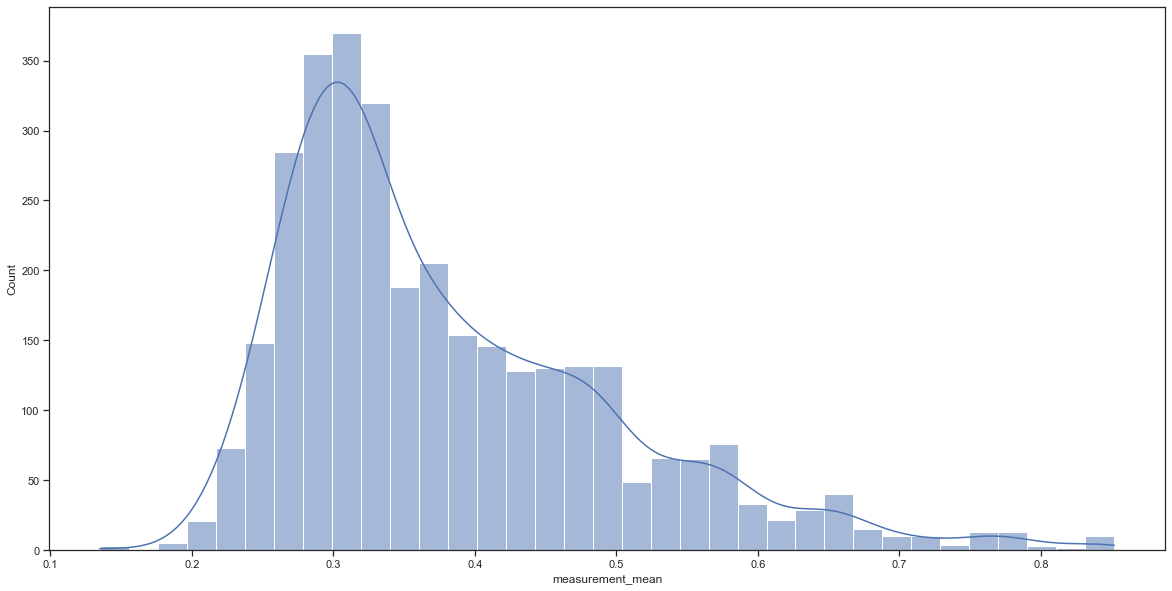

In [16]:
sns.histplot(mean_df, x='measurement_mean', kde=True)

Now we generate the new DataFrame without doing the mean, i.e. applying the wide-to-long transformation. We also add the new variable __location__.

In [17]:
# Apply the wide-to-long transformation in new DataFrame
melted = raw_data.melt(misc_cols, list(sensor_data), value_name='measurement', var_name='wavelength')
melted['location'] = melted.apply(lambda row: f'{row.field_id}, {row.position_id}, {row.spot_id}', axis=1)
melted.head()

,device_id,label1,label2,field_id,position_id,spot_id,mID,date,wavelength,measurement,location
0,6,good,issue_1,field_6,1,1,514234,2020-03-04,nir_1366,0.363926,"field_6, 1, 1"
1,6,good,issue_1,field_6,1,1,514236,2020-03-04,nir_1366,0.352420,"field_6, 1, 1"
2,6,good,issue_1,field_6,1,1,514238,2020-03-04,nir_1366,0.352814,"field_6, 1, 1"
3,5,bad,issue_4,field_6,2,1,514248,2020-03-04,nir_1366,0.382781,"field_6, 2, 1"
4,5,bad,issue_4,field_6,2,1,514251,2020-03-04,nir_1366,0.372411,"field_6, 2, 1"


<AxesSubplot:xlabel='measurement', ylabel='Count'>

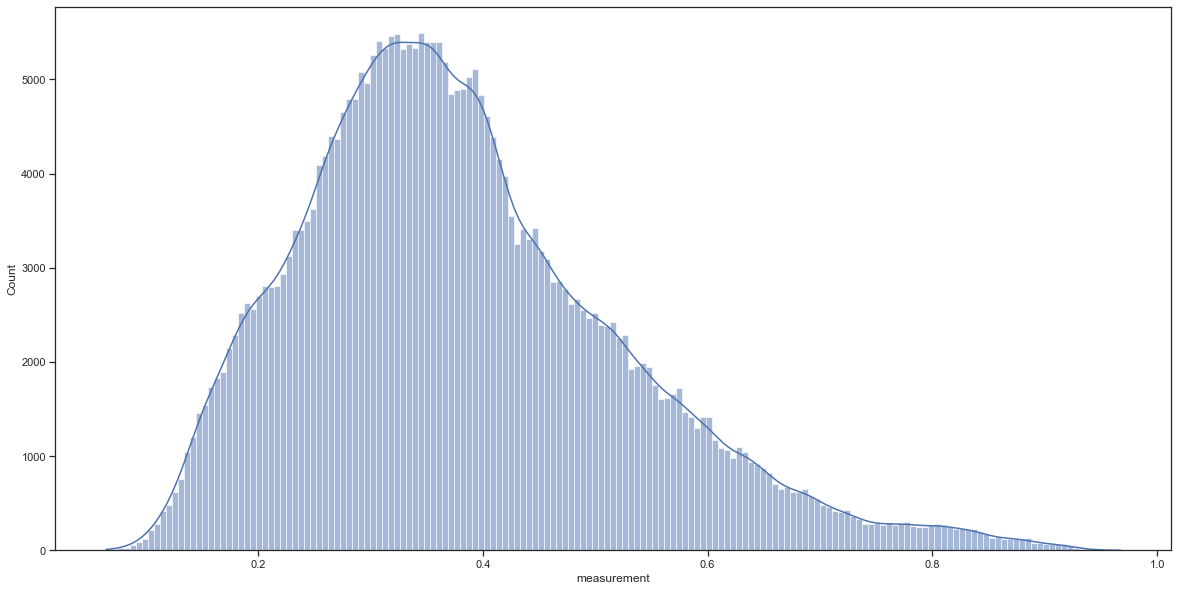

In [18]:
sns.histplot(melted, x='measurement', kde=True)

We see that the data distribution is the same for both Data Frames. However, with __melted__ we are not loosing any information. Therefore, we will continue working with it while is confortable. 

We now look into the variation of the measurements w.r.t. the fields. 

<AxesSubplot:xlabel='field_num', ylabel='measurement_mean'>

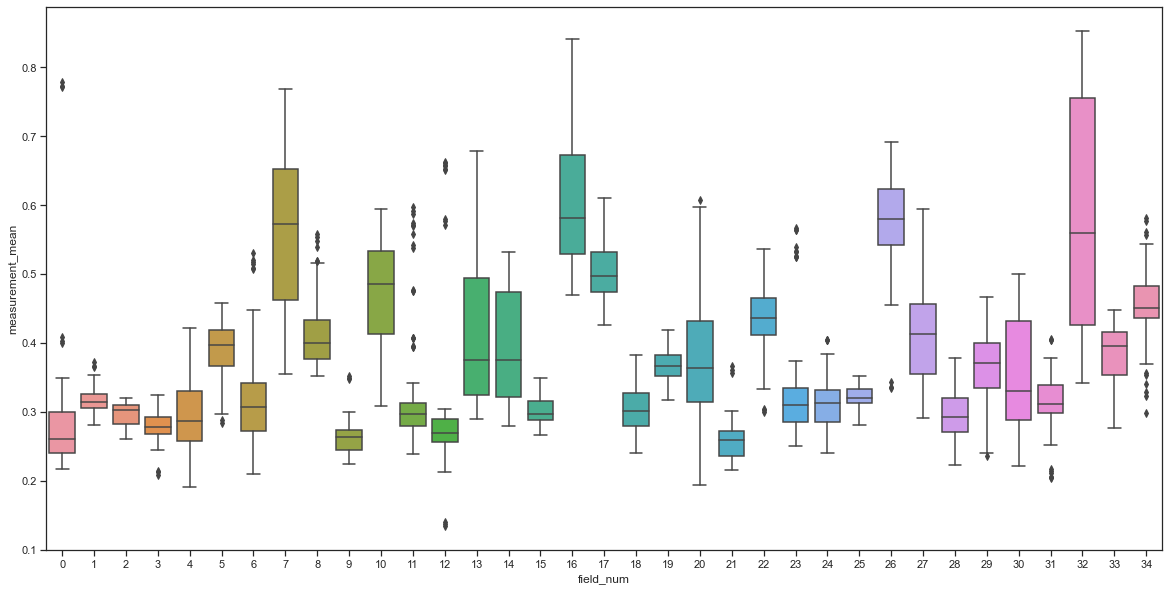

In [19]:
# Remove the string from field_id and add it to the DataFrame as a new numerical variable
# Helpful for visualization and possibly for later analysis.
fields = mean_df.field_id
mean_df['field_num'] = [int(field.replace('field_','')) for field in fields]

# Generate boxplot for measurements across fields
sns.boxplot(x="field_num", y="measurement_mean", data=mean_df)

There exist variation of the data across all of the fields. Specifcally, we see how certain fields have bigger measurement data. Exampels are fields: 7, 10, 16, 17, 26, 32. Let's inspect those fields closer.

<AxesSubplot:xlabel='field_num', ylabel='measurement'>

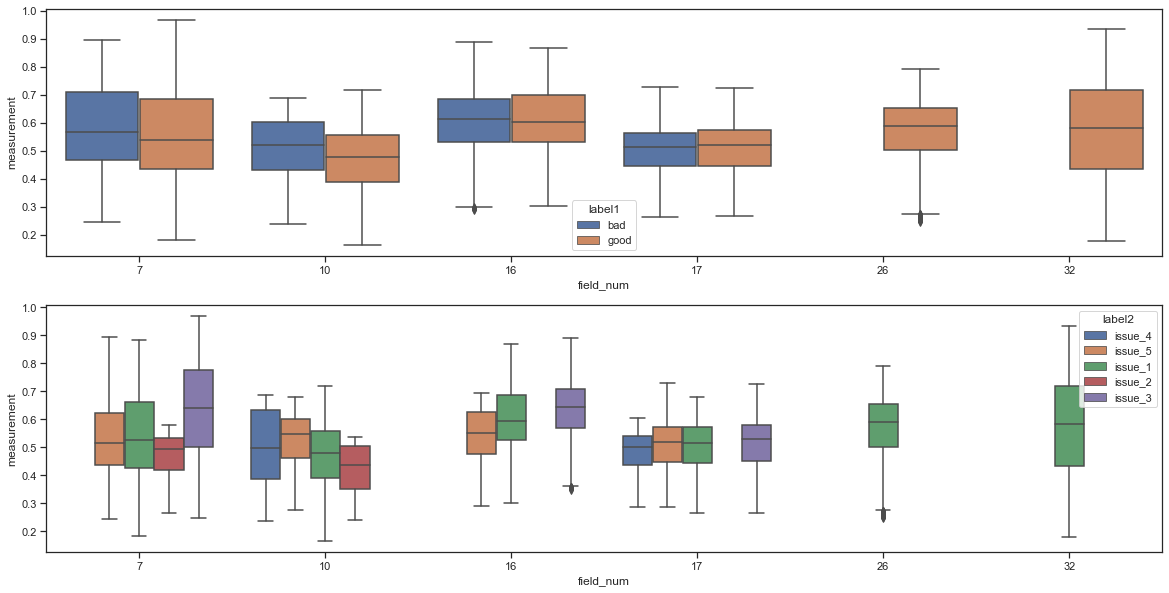

In [20]:
# define list of fields to inspect
inspect_fields = [7, 10, 16, 17, 26, 32]
# Slice melted with it and plot the same boxplot but now with label1 information
fields = melted.field_id

melted['field_num'] = [int(field.replace('field_','')) for field in fields]
inspected = melted[melted.field_num.isin(inspect_fields)]

f, axes = plt.subplots(2, 1)
sns.boxplot(data=inspected, x='field_num', y='measurement', hue='label1', ax=axes[0])
sns.boxplot(data=inspected, x='field_num', y='measurement', hue='label2', ax=axes[1])


We see how the data for field 26 and 32 are only of good measurements and issue_1.  This information will be useful later on when trying to find a rule to label the missing data. We could then cehck if any of the missing data is in any of these two fields and is labelled correctly by our rule. 

## Filling missing labels

In [21]:
raw_data[raw_data.label1 == 'good'].label2.value_counts()

issue_1    2541
issue_3     229
issue_2      82
issue_4      41
issue_5      17
issue_0       1
Name: label2, dtype: int64

In [22]:
raw_data[raw_data.label1 == 'bad'].label2.value_counts()

issue_3    117
issue_5    104
issue_4     83
issue_2     18
Name: label2, dtype: int64

In [23]:
missing_labels = mean_df[mean_df.label1.isna() | mean_df.label2.isna()]
missing_labels.head()


,measurement_mean,measurement_std,device_id,label1,label2,field_id,position_id,spot_id,mID,date,location,field_num
21,0.257363,0.062298,6,NaN,NaN,field_6,2,1,514481,2020-03-04,"field_6, 2, 1",6
54,0.300600,0.055018,5,NaN,NaN,field_6,4,1,514745,2020-03-04,"field_6, 4, 1",6
159,0.323209,0.061713,1,NaN,NaN,field_1,1,1,11940,2020-04-08,"field_1, 1, 1",1
257,0.446482,0.103647,8,NaN,NaN,field_33,2,2,731057,2020-04-08,"field_33, 2, 2",33
377,0.393576,0.078507,2,NaN,NaN,field_10,5,1,448893,2020-04-19,"field_10, 5, 1",10


From the previous density plots it seemed that the distribution of the label1==good was matching the issue 1. However, we can not make the direct matching since we have ca. 350 measurements labeled as good that have issues. This number is bigger than the values of issues being labeled as bad measurements .Also, we see how bad labeled measurements can have the issue 0 or 1 as label2.

In [24]:
dist_cols = ['measurement_mean', 
             'measurement_std',
             'label1', 
             'label2']

# DataFrame with only the rows having missing labels. 
missing_labels = mean_df[mean_df.label1.isna() | mean_df.label2.isna()]
for i, row in missing_labels.iterrows():
    # DataFrame with the measurements that have the same location and device id with the missing one
    measurements_around = mean_df[(mean_df.location == row.location)  &
                                  (mean_df.device_id == row.device_id) & 
                                  (mean_df.mID != row.mID)]
    # DataFrame with the mean averages groubed by the different labels around the missing labels
    local_label_averages = measurements_around[dist_cols].groupby(['label1', 'label2']).mean()
    # Diferenece from the missing one to the neigbhouring label averages and add 'mse'
    deltas = (row[dist_cols] - local_label_averages)
    deltas['mse'] = deltas.measurement_mean**2 + deltas.measurement_std**2
    
    # label closest to the mean of neighbouring labels.
    closest_label = deltas[deltas.mse == deltas.mse.min()].index
    for label, col_name in zip(*closest_label, closest_label.names):
        missing_labels.at[i, col_name] = label

missing_labels

,measurement_mean,measurement_std,device_id,label1,label2,field_id,position_id,spot_id,mID,date,location,field_num
21,0.257363,0.062298,6,bad,issue_3,field_6,2,1,514481,2020-03-04,"field_6, 2, 1",6
54,0.300600,0.055018,5,bad,issue_4,field_6,4,1,514745,2020-03-04,"field_6, 4, 1",6
159,0.323209,0.061713,1,good,issue_1,field_1,1,1,11940,2020-04-08,"field_1, 1, 1",1
257,0.446482,0.103647,8,good,issue_1,field_33,2,2,731057,2020-04-08,"field_33, 2, 2",33
377,0.393576,0.078507,2,good,issue_1,field_10,5,1,448893,2020-04-19,"field_10, 5, 1",10
447,0.476026,0.162029,9,good,issue_1,field_11,1,1,499410,2020-05-06,"field_11, 1, 1",11
588,0.265204,0.074578,9,good,issue_1,field_12,4,3,513258,2020-05-26,"field_12, 4, 3",12
729,0.543341,0.067307,6,good,issue_1,field_32,2,1,978533,2020-06-07,"field_32, 2, 1",32
1016,0.257378,0.066260,10,good,issue_1,field_28,1,2,762964,2020-07-07,"field_28, 1, 2",28
1117,0.448849,0.069755,2,good,issue_3,field_34,1,2,761957,2020-07-07,"field_34, 1, 2",34


To find a rule to fill the missing labels, I decided to look at the measurements that have the same location (previously defined as the combination of field, position and spot) and same device id. There are cases where it is straightforward to see the labelling since all of the neighbouring measurements are assigned to the same labels. However, there are some cases where this is not the case and makes the task not trivial. Exact same location, date and device id but still different labels. These cases are difficult to distinguish. Therefore, I decided to look at the distance from the measurement labels and pick the closest one.

By manually inspecting the data, the cases where it is hard to distinguish among the labels, the applied rule seem to be the most fitting one. Let's inspect the one with field_18.

In [25]:
mean_df[(mean_df.field_id == 'field_18')  & (mean_df.position_id == 1)  & (mean_df.spot_id == 1)  &
        (mean_df.device_id == 10)]

,measurement_mean,measurement_std,device_id,label1,label2,field_id,position_id,spot_id,mID,date,location,field_num
1790,0.268397,0.079624,10,good,issue_1,field_18,1,1,637320,2020-08-17,"field_18, 1, 1",18
1791,0.269188,0.080001,10,good,issue_1,field_18,1,1,637322,2020-08-17,"field_18, 1, 1",18
1792,0.267899,0.080277,10,good,issue_1,field_18,1,1,637325,2020-08-17,"field_18, 1, 1",18
1797,0.274636,0.077035,10,good,issue_1,field_18,1,1,637358,2020-08-17,"field_18, 1, 1",18
1799,0.272177,0.077779,10,bad,issue_5,field_18,1,1,637360,2020-08-17,"field_18, 1, 1",18
1801,0.271192,0.078179,10,bad,issue_5,field_18,1,1,637363,2020-08-17,"field_18, 1, 1",18
1805,0.245009,0.068677,10,NaN,NaN,field_18,1,1,637388,2020-08-17,"field_18, 1, 1",18
1806,0.243663,0.069621,10,good,issue_1,field_18,1,1,637390,2020-08-17,"field_18, 1, 1",18
1807,0.240595,0.070637,10,good,issue_1,field_18,1,1,637393,2020-08-17,"field_18, 1, 1",18


From looking at the measurement data is really hard to tell the difference among them. However, the average among the good ones is closer and we can assign it as good / issue_1.

In [26]:
# Check for the actual filled labels
missing_labels[missing_labels.field_id=='field_18']

,measurement_mean,measurement_std,device_id,label1,label2,field_id,position_id,spot_id,mID,date,location,field_num
1805,0.245009,0.068677,10,good,issue_1,field_18,1,1,637388,2020-08-17,"field_18, 1, 1",18


The rule appears to fins reasonable labels to the missing data. Again, for the majority of the 22 missing labels, the rule is straight forward. However, there are a couple of measurements which are really hard to distinguish.

## Seasonal and spatial patterns in the given labels investigation

To check the spatial and seasonal data we are going to plot the measurement data across dates and across the new variable location (field + position + spot). Then, we are going to check the labels in the given distributions.

<AxesSubplot:xlabel='date', ylabel='measurement_mean'>

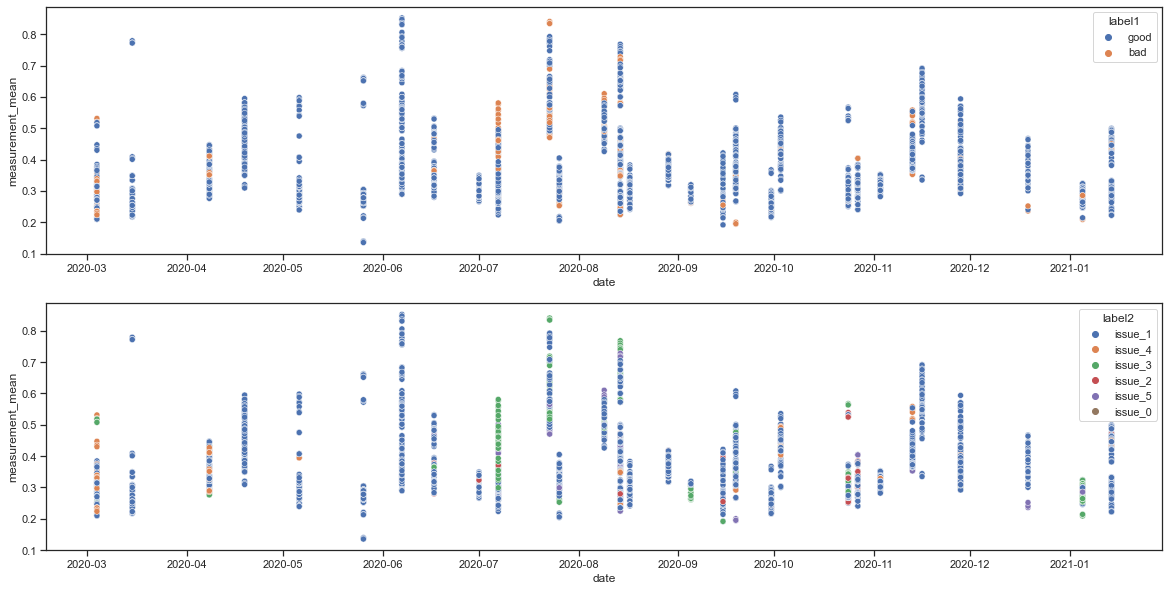

In [27]:
# Plotting scatterplots across dates for issue1 and issue2
f, axes = plt.subplots(2, 1)
sns.scatterplot(data=mean_df, 
                x='date', 
                y='measurement_mean', 
                hue='label1',
                ax=axes[0])

sns.scatterplot(data=mean_df, 
                x='date', 
                y='measurement_mean', 
                hue='label2',
                ax=axes[1])

We again see how dates with no label1 ==good, direclty relate to issue_1. Also, some specific issues from label 2 are happening on a given day or week. For example, in July 2020, many of the bad measuremetns seem to relate to the issue3. This might tell us that issue_3 is related to terrain condition (given by the weather of that time) rather than the sensor itself.  

Let's investigate now the spatial data given our new variable location.

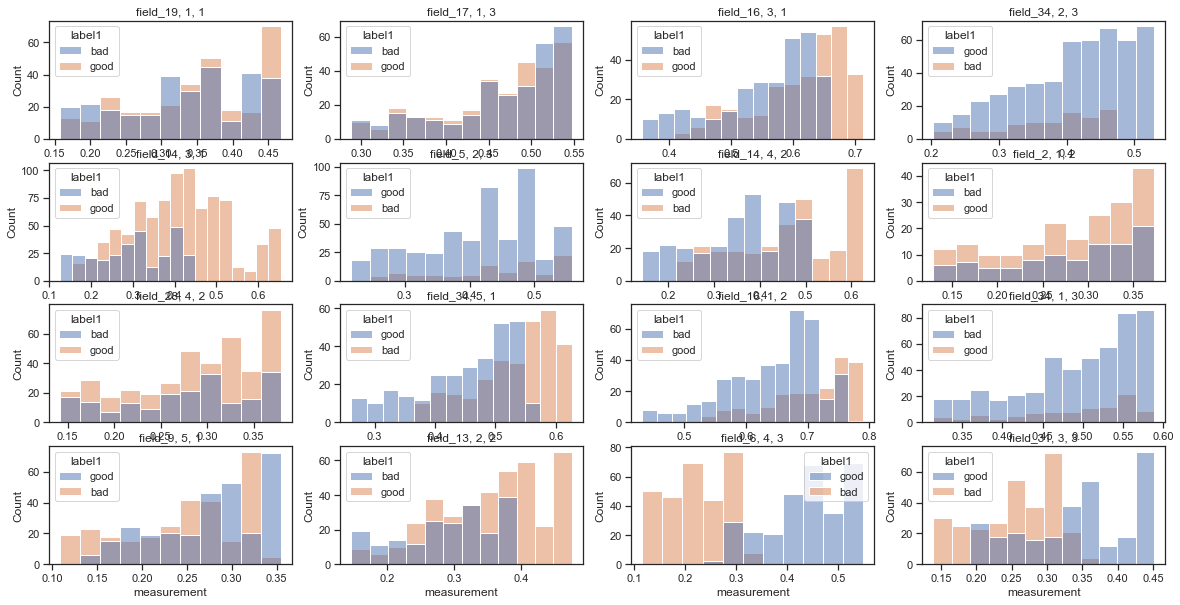

In [28]:
# Check for locations that have bad measurements and pick randomly
locations = melted[melted.label1 == 'bad'].location.unique()
locations = np.random.choice(list(locations), size=16)


# Plot the distribution of the measuremetns in the bad locations 
f, axes = plt.subplots(4, 4)
for location, ax in zip(locations, axes.flatten()):
    sns.histplot(data=melted[melted.location == location], 
                 x='measurement',
                 hue='label1',
                 ax=ax)
    ax.set_title(location)
plt.show()

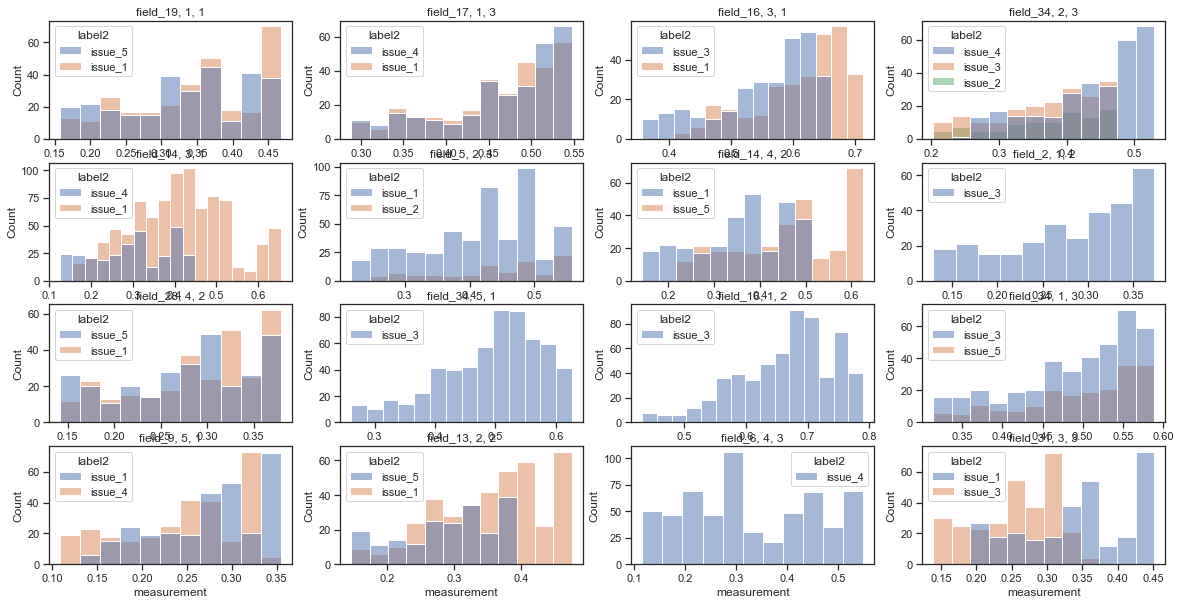

In [29]:
# For the same random locations, plot the distribution for label2
f, axes = plt.subplots(4, 4)

for location, ax in zip(locations, axes.flatten()):
    sns.histplot(data=melted[melted.location == location], 
                 x='measurement',
                 hue='label2',
                 ax=ax)
    ax.set_title(location)
plt.show()

It appears that given a certain location the distribution of the measurements sometimes is clearly separable from labels. For example in __field_13,2,2__ we see a clear difference of the measurement data across labels. In short, this new location variable will be useful to discriminate among labels for our model.

<AxesSubplot:>

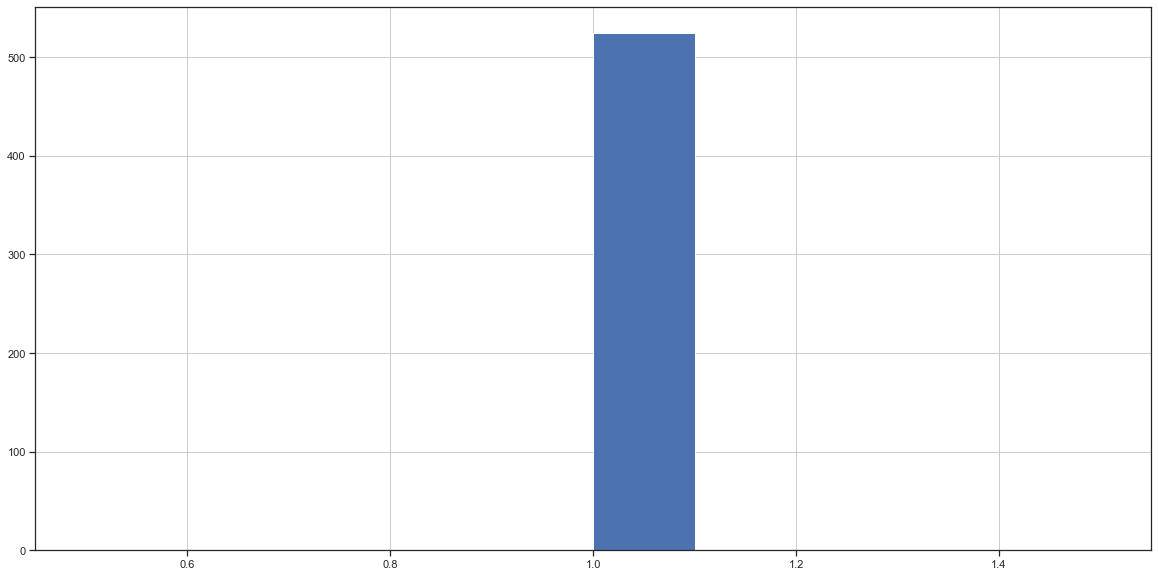

In [30]:
date_counts = melted.groupby('location').date.nunique()
date_counts.hist()

We also see that there is only one measurment per date and location. Therefore, the date and location are dependent on each other and will not give information in order to predict the labels. 

Finally, to see whether the device ID has an infulence on the labels, let's plot the measurment distribution among them.

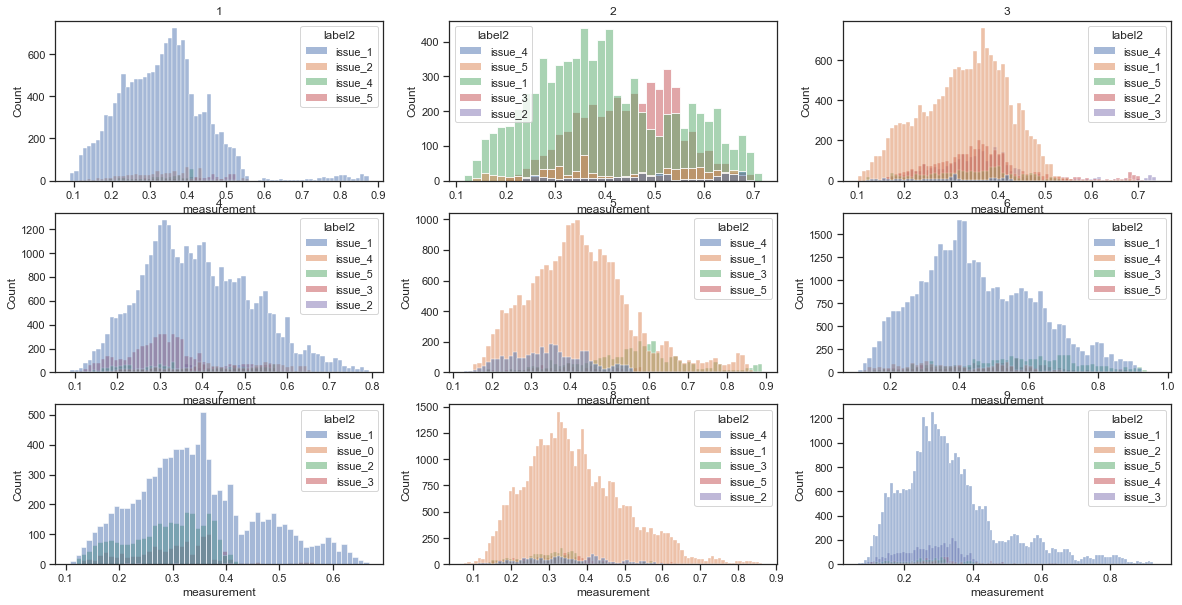

In [31]:
# For the same random locations, plot the distribution for label2
f, axes = plt.subplots(3, 3)

for device_id, ax in zip(range(1, 10), axes.flatten()):
    sns.histplot(data=melted[melted.device_id == device_id], 
                 x='measurement',
                 hue='label2',
                 ax=ax)
    ax.set_title(device_id)
plt.show()

Again, the distributions look really similar across device_id and labels. Thus, we do nor seen any evidence that device id has a strong influnece on the labels.

## Classifier models



Let's first add the missing label data to raw_data and apply the wide-to-long transformation again. Then, in order ot use a classifier taking the features such as locations and device id, we will need to one-hot encode the variables. Then, we will train two classifiers based on the two data frames, melted and mean_df. We will use a __gradient boosting__ classifier. The boosting classifier will create multiple predictors that will try to imporve consecutively and, ideally, give a better result than a single model. 


Since we are trying to classify the label2 based only on the bad measurements from label 1, we can already know that our oredictor will only have 4 possible targets (issue 2,3,4 and 5).

In [40]:
# fill na values with missing_labels DF
raw_data = raw_data.fillna(missing_labels)

# Apply same transforamtion
melted = raw_data.melt(misc_cols, list(sensor_data), value_name='measurement', var_name='wavelength')
melted['location'] = melted.apply(lambda row: f'{row.field_id}, {row.position_id}, {row.spot_id}', axis=1)


# Filter by only bad labels
melted_bad = melted[melted.label1 == 'bad']

 
# Apply one-hot encoding to location and device
melted_bad = pd.get_dummies(melted_bad, prefix='location', columns=['location'])
melted_bad = pd.get_dummies(melted_bad, prefix='device', columns=['device_id'])

# Defining feature and target variables
target = ['label2']
features = ['measurement'] +            \
           [col for col in melted_bad if 'location_' in col]  +  \
           [col for col in melted_bad if 'device_' in col] 


# Manually defining train test split not to share same measurements ids
mIDs = melted_bad.mID.unique()
test_mIDs = np.random.choice(mIDs, size=int(0.33*len(mIDs)))

train, test = melted_bad[~melted_bad.mID.isin(test_mIDs)], melted_bad[melted_bad.mID.isin(test_mIDs)]

X_train, X_test = train[features].to_numpy(), test[features].to_numpy()
y_train, y_test = train[target].to_numpy().ravel(), test[target].to_numpy().ravel()


In [42]:
# Defining the gradient boosting classifier and fitting
clf_melted = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5).fit(X_train, y_train)

# Calculating the score on the test set and reporting 
y_pred = clf_melted.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     issue_2       0.68      0.67      0.67       294
     issue_3       0.80      1.00      0.89      3038
     issue_4       1.00      0.89      0.94      2744
     issue_5       0.89      0.75      0.81      3038

    accuracy                           0.87      9114
   macro avg       0.84      0.83      0.83      9114
weighted avg       0.88      0.87      0.87      9114



In [34]:
# Compute feature importance 
sorted([*zip(clf_melted.feature_importances_, features)], key=lambda t: t[0], reverse=True)[:10]

[(0.37231175588263393, 'location_field_19, 5, 3'),
 (0.08900938573874013, 'measurement'),
 (0.025172648940984917, 'device_10'),
 (0.015989188263620408, 'device_1'),
 (0.014967784284790564, 'location_field_1, 1, 3'),
 (0.014896872619172394, 'location_field_33, 5, 2'),
 (0.014058314717172, 'location_field_6, 4, 2'),
 (0.014031271416005008, 'device_2'),
 (0.013733733204067549, 'location_field_6, 2, 1'),
 (0.012329175653711184, 'location_field_3, 1, 2')]

Now we do the same thing only based on the mean data DataFrame. 

In [43]:
mean_df = mean_df.fillna(missing_labels)

# Filter by only bad labels
mean_bad = mean_df[mean_df.label1 == 'bad']

 
# Apply one-hot encoding to location and device
mean_bad = pd.get_dummies(mean_bad, prefix='location', columns=['location'])
mean_bad = pd.get_dummies(mean_bad, prefix='device', columns=['device_id'])

# Defining feature and target variables
target = ['label2']
features = ['measurement_mean'] +            \
           [col for col in mean_bad if 'location_' in col]  +  \
           [col for col in mean_bad if 'device_' in col] 

# Here ewe can use scikit learn in-buit function to split train and test data.
X, y = mean_bad[features].to_numpy(), mean_bad[target].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [44]:
# Defining the gradient boosting classifier and fitting
clf_mean = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5).fit(X_train, y_train)

# Calculating the score on the test set and reporting 
y_pred = clf_mean.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     issue_2       0.50      0.20      0.29         5
     issue_3       0.95      0.91      0.93        43
     issue_4       1.00      0.84      0.91        25
     issue_5       0.73      0.91      0.81        35

    accuracy                           0.86       108
   macro avg       0.79      0.72      0.73       108
weighted avg       0.87      0.86      0.86       108



In [45]:
sorted([*zip(clf_mean.feature_importances_, features)], key=lambda t: t[0], reverse=True)[:10]

[(0.1946606950474121, 'measurement_mean'),
 (0.04121595292088148, 'device_10'),
 (0.029215333621881927, 'location_field_6, 4, 2'),
 (0.02908847678263827, 'location_field_3, 1, 2'),
 (0.027599386636036536, 'location_field_33, 5, 2'),
 (0.025498297865182873, 'device_5'),
 (0.02269518004236354, 'location_field_1, 1, 2'),
 (0.021145021247448572, 'location_field_9, 5, 1'),
 (0.02018711713982299, 'location_field_6, 1, 2'),
 (0.015485248298363992, 'location_field_23, 1, 1')]

We see how both classifiers report similar classification metrics for the same task.